## RBC Model With Different Values for $\beta$ 

In this experiment, we wish to model the Real Business Cycle model, but evaluate what happens when the consumption discount factor $\beta$ changes value. The discount factor $\beta \in \mathbb{R}$ and $\beta \in (0,1)$. It is a value that tells us the value that a household places on future consumption. What happens to the impulse responses to labor, output, and consumption in the face of different values placed on future consumption for households? 

Recall that the Real Business Cycle model posits that the main driver of the macroeconomic fluctuations that take place over time are due to changes to "total factor productivity", the A in the Cobb-Douglas production function. One may think of this as a "solow residual", as it is the remainder of Y after being divided by capital and labor in the Cobb-Douglas production function. Thus, we can think of these as technology changes, institutions, etc. 

Here, we are focused on how the impulse responses to labor, output, and consumption change differently after a shock to TFP, based on the value for the consumption discount factor $\beta$

When $\beta$ is larger, it indicates that the household places a larger value on future consumption. Will this cause labor in the immediate to go up? Down? What about consumption? Let's find out!

In [109]:
#Importing packages
import numpy as np #Numpy for array operations
import pandas as pd #Pandas for dataframes and data management
import linearsolve as ls #Linearsolve for approximating FOC solutions
import matplotlib.pyplot as plt #Matplotlib for plotting
import seaborn as sns #Seaborn for nicer looking graphs
plt.style.use('classic')
plt.rcParams['figure.facecolor'] = 'white'

These are the equilibrium conditions for the Real Business Cycle Model:
\begin{align}
\frac{1}{C_t} & = \beta E_t \left[\frac{\alpha A_{t+1}K_{t+1}^{\alpha-1}L_{t+1}^{1-\alpha} +1-\delta }{C_{t+1}}\right]\\
\frac{\varphi}{1-L_t} & = \frac{(1-\alpha)A_tK_t^{\alpha}L_t^{-\alpha}}{C_t} \\
Y_t & = A_t K_t^{\alpha}L_t^{1-\alpha}\\
K_{t+1} & = I_t + (1-\delta) K_t\\
Y_t & = C_t + I_t\\
\log A_{t+1} & = \rho \log A_t + \epsilon_{t+1}
\end{align}

where $\epsilon_{t+1} \sim \mathcal{N}(0,\sigma^2)$. 

These are the values for our parameters that we will be utilizing in our experiment:
| $$\sigma$$ | $$\rho$$  | $$\varphi$$ | $$\alpha$$ | $$\delta $$ |
|------------|-----------|-------------|------------|-------------|
| 0.006      | 0.75      | 1.7317      | 0.35       |  0.025      |



In [111]:
#Store the parameters to be utilized in our model
parameters = pd.Series({
    'rho': 0.75,
    'phi': 1.7317,
    'alpha': 0.35,
    'delta': 0.025
})

In [112]:
#Create a list storing our exogenous state variables, our endogenous state variables, and co-state variables
# a = TFP, k = capital, y = output, c = consumption, i = investment, l = labor

exo_states, endo_states, costates = ['a'], ['k'], ['y', 'c', 'i', 'l']


In [113]:
#Create a function that will evaluate the equilibrium conditions using FOCs for the equations needed in the RBC model
def equations(variables_forward,variables_current,parameters):
    
    #Parameters
    p = parameters
    
    #Value of variable at time t
    cur = variables_current
    
    #Value of variable at time t+1
    fwd = variables_forward

    #Euler equation
    mpk = p.alpha*fwd.a*fwd.k**(p.alpha-1)*fwd.l**(1-p.alpha)
    euler_equation = p.beta*(mpk+1-p.delta)/fwd.c - 1/cur.c
    
    #Labor-leisure
    mpl = (1-p.alpha)*cur.a*cur.k**p.alpha*cur.l**(-p.alpha)
    labor_leisure = mpl/cur.c - p.phi/(1-cur.l)
    
    #Production Function
    production_function = cur.a*cur.k**p.alpha*cur.l**(1-p.alpha) - cur.y
    
    #Capital Evol
    capital_evolution = cur.i + (1 - p.delta)*cur.k - fwd.k
    
    #Market Clearing
    market_clearing = cur.c+cur.i - cur.y
    
    #TFP Evol
    tfp_process = p.rho*np.log(cur.a) - np.log(fwd.a)
    
    #Put the equilibrium conditions into one array
    return np.array([
        euler_equation,
        labor_leisure,
        production_function,
        capital_evolution,
        market_clearing,
        tfp_process
        ])

In [114]:
#Initialize the model
rbc_model = ls.model(equations = equations,
                     exo_states=exo_states,
                     endo_states=endo_states,
                     costates=costates,
                     parameters=parameters)

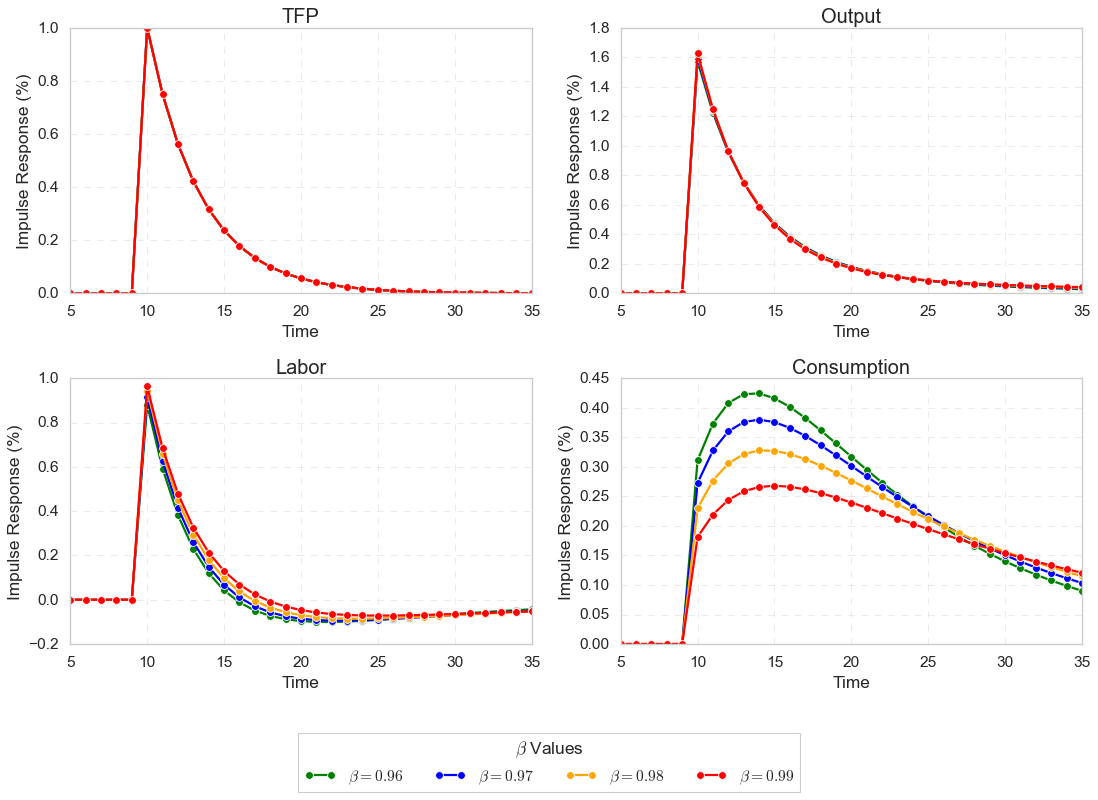

In [115]:
#Create a list for our beta values, our variable names, and our graph titles
beta_values, variables, titles = [0.96, 0.97, 0.98, 0.99], ['a', 'y', 'l', 'c'], ['TFP', 'Output', 'Labor', 'Consumption']
#Create a list for colors we will be using for each line corresponding to one beta value
colors = ['green', 'blue', 'orange', 'red'] 

#Initialize an empty list
data = []
#Initiate a for loop to go through the different values for beta
for beta in beta_values:
    #Update the beta parameter in the rbc model
    rbc_model.parameters['beta'] = beta
    #Compute the steady state guess
    rbc_model.compute_ss([1, 4, 1, 1, 1, 0.5])
    #Approximate the solution
    rbc_model.approximate_and_solve()
    #Compute the impulse responses to a 1% shock to TFP in period 5
    rbc_model.impulse(T=31, t0=5, shocks=[0.01])
    #Create range for time of the responses
    time_range = range(5, len(rbc_model.irs['e_a']['a']) + 5)
    #Initiate a for loop to go through varaibles for each set of information
    for var in variables:
        data.append(pd.DataFrame({
            'Time': time_range,
            'Impulse Response': rbc_model.irs['e_a'][var] * 100,
            'Beta': beta,
            'Variable': var
        }))
#Concatenate the data into a dataframe
df_all = pd.concat(data)

#Create graph style with Seaborn
sns.set(style="whitegrid", palette="muted", font_scale=1.3)

#Create figure and axes to plot
fig, axes = plt.subplots(2, 2, figsize=(14, 9))
axes = axes.flatten()

#Initiate a for loop to go through the axes we created
for i, ax in enumerate(axes):
    #Create plot for the grid
    legend_flag = True if i == 0 else False
    #Line creation
    sns.lineplot(data=df_all[df_all['Variable'] == variables[i]], 
                 x='Time', 
                 y='Impulse Response', 
                 hue='Beta', 
                 ax=ax, 
                 lw=2, 
                 errorbar=None,  
                 marker='o', 
                 markersize=7, 
                 palette=colors, 
                 legend=legend_flag)
    #Setting labels for each axis
    ax.set(title=titles[i], xlabel='Time', ylabel='Impulse Response (%)')
    
    #Setting the tick size for x and y axis
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)

    #Change the font for the title
    ax.set_title(titles[i], fontsize=18)

    #Add grid
    ax.grid(True, linestyle='--', linewidth=0.7, alpha=0.5)

    #Take out the legend
    if i == 0:
        ax.legend_.remove()

#Make layout more compact
plt.tight_layout()

#Add a shared legend at the bottom
handles, labels = axes[0].get_legend_handles_labels()

#Instead of "Beta", replace it with the math symbol $\beta$ to make it look nicer
labels = [r'$\beta = ' + str(label) + r'$' for label in labels]
fig.legend(handles, labels, loc='center', bbox_to_anchor=(0.5, -0.075), ncol=4, fontsize=14, title=r'$\beta$ Values')
plt.savefig("RBC_betas.png", dpi=300, bbox_inches="tight")
#Show the plot
plt.show()


## Results, Analysis, and Conclusions

We note that from our graphs, we notice that there is a difference in the impulse responses to labor and consumption for different values of the consumption discount factor $\beta$. Note that in the Labor graph, we see that there is a stronger response to labor than there is for the lower values of $\beta$. Why? Well, because the higher $\beta$ households place a higher value on future consumption relative to the present, they need to be more laborious to be able to consume more in the future. However, for lower $\beta$ households, present consumption is actually more important, leading to a lower labor stimulation, as households will focus less on having money to spend in future time periods.

In our consumption graph, we note that there is a much bigger shock to consumption for the lower $\beta$ value household group. This is of course expected, as we know that they are placing a higher value on current consumption compared to future consumption. What's interesting is that as we continue on over time, we see that the $\beta = .99$ group ends up over taking all the other lower $\beta$ value groups, as they are more interested in future consumption, and likely have the savings and money to do so from their prior labor. 

We know that because of the euler equation, households want to have a smooth consumption process, where their future consumption is equal to a proportion of their current consumption, and thus households will not simply send all of their new income from labor to consumption, as that is something they prefer to keep smooth. 

This provides us some interesting insights into how the economy would respond from the same shock to total factor productivity, but for differing values for our consumption discount factor $\beta$